In [ ]:
# ~ Καπετάνιος Δημήτριος 

# Μάθημα: Ειδικά θέματα Επεξεργασίας/Ανάλυσης Σημάτων & Εικόνων.
# Καθηγητής: κος Μ. Σαβελώνας PhD
# Τμήμα: Πληροφορικής με Εφαρμογές στη Βιοϊατρική
# Σχολή Θετικών Επιστημών::Πανεπιστήμιο Θεσσαλίας::Λαμία
# Ημερομηνία:  09/05/2023

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [1]:
from IPython.display import Markdown

markdown_text = """
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb)
"""

display(Markdown(markdown_text))


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb)


In [ ]:
from google.colab import drive
drive.flush_and_unmount()
!rm -rf /content/sam_vit_h_4b8939.pth

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## NVIDIA

**CUDA** (or Compute Unified Device Architecture) is a parallel computing platform and application programming interface (API) that allows software to use certain types of graphics processing units (GPUs) for general purpose processing, an approach called general-purpose computing on GPUs (GPGPU). CUDA is a software layer that gives direct access to the GPU's virtual instruction set and parallel computational elements, for the execution of compute kernels.

In the context of machine learning and artificial intelligence, CUDA can significantly speed up computing processes. For instance, when training neural networks, which involves lots of matrix and vector operations, these operations can be parallelized and thus performed significantly faster on a GPU. This is especially true for deep learning, where neural networks can be very large and require a lot of computational resources.

CUDA specifically is proprietary to NVIDIA, meaning it only works with NVIDIA GPUs. There are other GPGPU frameworks available that work with GPUs from other manufacturers, like OpenCL (Open Computing Language), but CUDA remains very popular due to its efficiency and the widespread use of NVIDIA GPUs in the machine learning field.

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


Let's make sure that we have access to a GPU.
We can use `nvidia-smi` command to do that.

In [4]:
!nvidia-smi

Thu May 11 08:40:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Environment Set-up

The code requires `python>=3.8`, as well as `pytorch>=1.7` and `torchvision>=0.8`. 

Installing both PyTorch and TorchVision with CUDA support is strongly recommended.

In [5]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
!python --version

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
Python 3.10.11


In [6]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
        
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-jsysz8o3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-jsysz8o3
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=52e67eaf31d507eae8ba17590aab66b435a5e28430dba65af82d73688bcfd58d
  Stored in directory: /tmp/pip-ephem-wheel-cache-9_ysy3gj/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-05-11 08:40:44--  https://dl.fbaipublicfiles.com/segment_anything/s

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os

In [8]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [9]:
image = cv2.imread('/content/drive/MyDrive/Bruna/pics/compressed/puppy_1.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

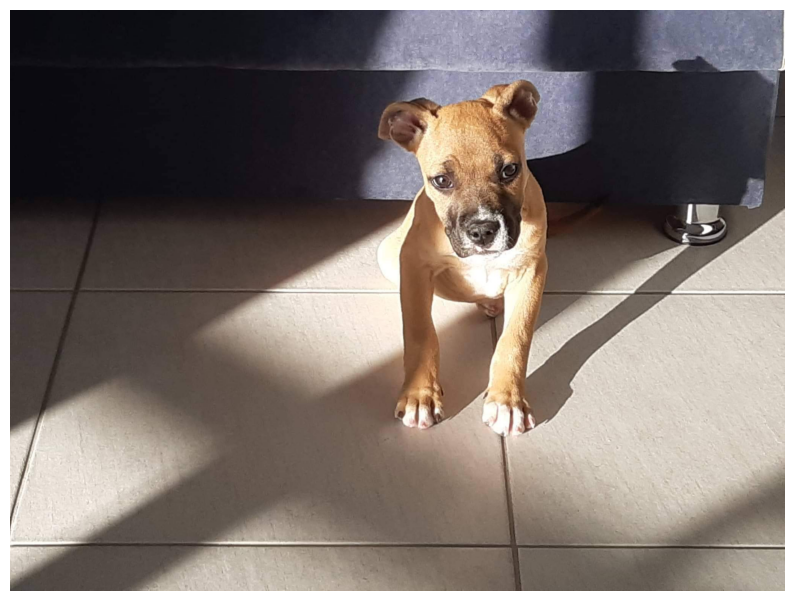

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [11]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [12]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [13]:
print(len(masks))
print(masks[0].keys())

46
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [14]:
masks

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 269327,
  'bbox': [971, 189, 447, 936],
  'predicted_iou': 1.031026840209961,
  'point_coords': [[1184.0, 552.0]],
  'stability_score': 0.9845487475395203,
  'crop_box': [0, 0, 2048, 1536]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 1880583,
  'bbox': [0, 170, 2

Show all the masks overlayed on the image.

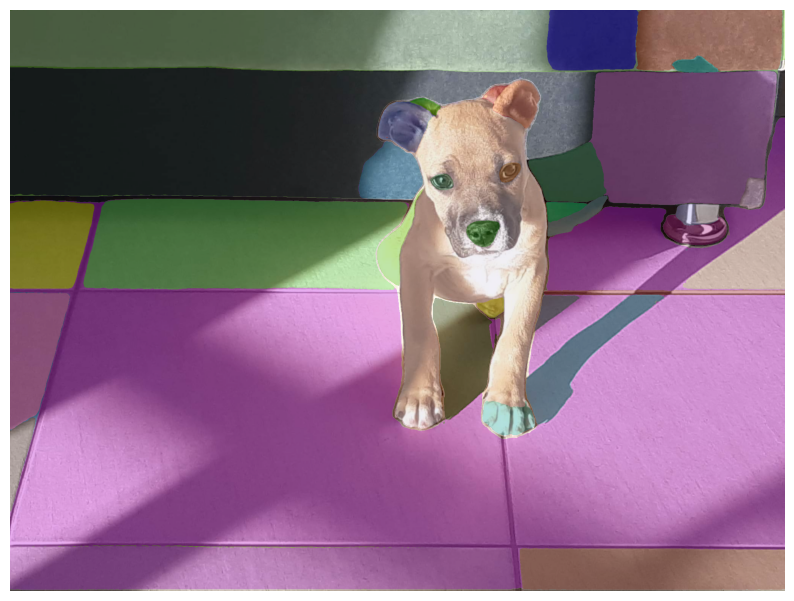

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [18]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py#L35

In [19]:
masks_2 = mask_generator_2.generate(image)

In [20]:
len(masks_2)

51

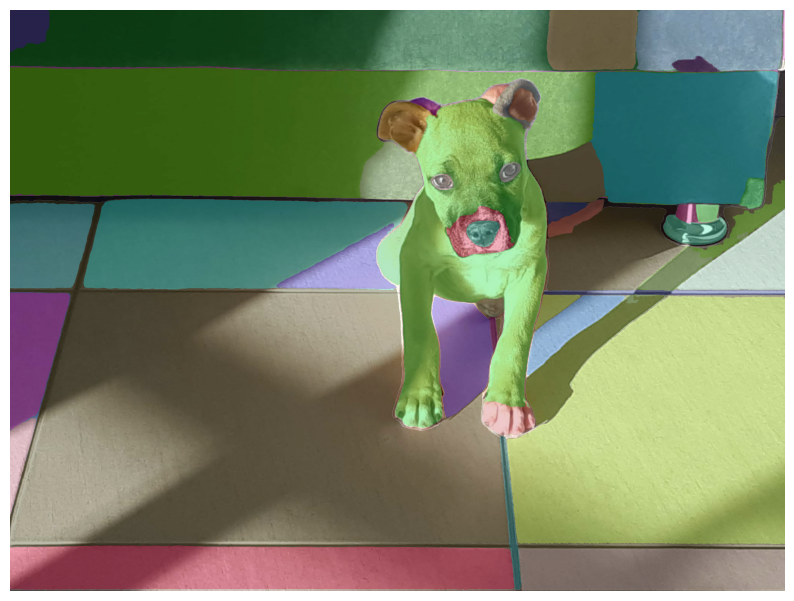

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks_2)
plt.axis('off')
plt.show() 

In [22]:
mask_generator_3 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [23]:
masks_3 = mask_generator_3.generate(image)

In [24]:
len(masks_3)

37

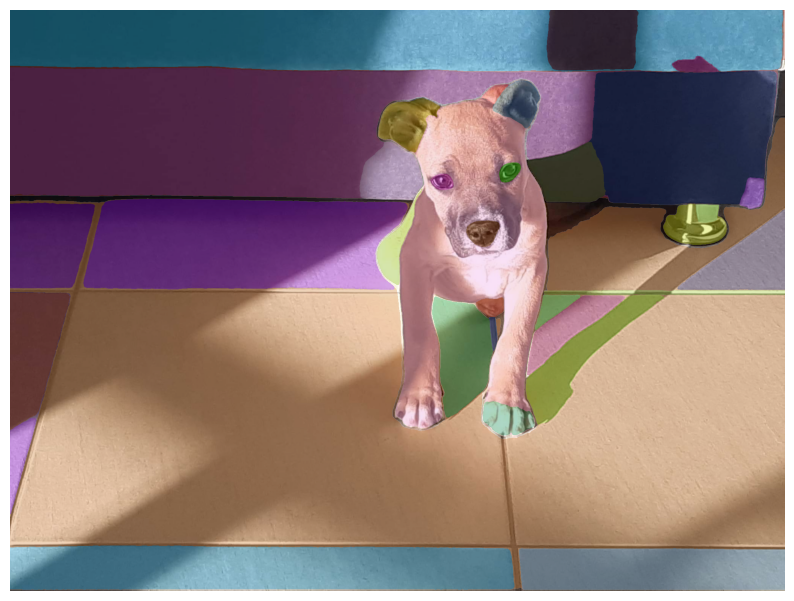

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks_3)
plt.axis('off')
plt.show() 

In [26]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/drive/1D6vxZ8uBoNPumDbsXiPh2hOqj9UStO7A?authuser=1">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))